## Seletor de conceito de arranjo submarino
Versão 2: com otimizador de localização da plataforma<br>
Versão 3: leitura externa das coordenadas dos poços<br>
Versão 4: leitura externa dos custos, custo de linhas calculado por fixo+distância*variável

### Instalação e carregamento das bibliotecas de GA em python

In [1]:
import random
import numpy as np
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import math
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

### Inputs do programa

In [2]:
#constantes importantes
LDA = 2500 # lâmina de água
maxP_SDU = 2 # máximo de produtores por SDU

In [3]:
# nomes, coordenadas e tipos dos poços devem estar no arquivo 'pocos.csv'
pocos = pd.read_csv('pocos.csv',names=['Nome','X','Y','Tipo'])

#pocos[['X','Y']] += np.random.normal(scale=500,size=(pocos.shape[0],2))

meanpos = list(pocos[['X','Y']].mean())
#pocos['X'] = pocos['X'] - meanpos[0]
#pocos['Y'] = pocos['Y'] - meanpos[1]
minmaxX = [pocos['X'].min(), pocos['X'].max()]
minmaxY = [pocos['Y'].min(), pocos['Y'].max()]
ampl = [minmaxX[1]-minmaxX[0],minmaxY[1]-minmaxY[0]]

pocos

,Nome,X,Y,Tipo
0,WAG1,485.699422,796.459049,W
1,WAG2,6036.900474,-5480.519026,W
2,WAG3,5289.208571,-615.039582,W
3,WAG4,-1577.096057,3196.922295,W
4,WAG5,-4672.499098,1792.671609,W
5,WAG6,-2930.926974,-1306.364818,W
6,PO1,-2282.575846,298.398152,P
7,PO2,6157.279148,-2152.901390,P
8,PO3,4862.131934,-2910.836093,P
9,PO5,-2356.923793,1272.194585,P


In [4]:
#dados de custos e dados básicos dos manifolds
custoeq = pd.read_csv('custoeq.csv',index_col=0,header=0)
custoeqaux = pd.DataFrame({'linhas':[['IWAG','Umb'],['IA','Umb'],['Umb'],['GL','Umb']],\
                      'pocos':[['W'],['A'],['A','W','G','P'],['P']],'qnt':[0,0,0,0]},\
                      index=['MSIAG','MSIA','SDU','MSGL'])
custoeq = pd.concat([custoeq,custoeqaux],axis=1,join='inner')

custolin = pd.read_csv('custolin.csv',index_col=0,header=0)
custolin = pd.concat([custolin,pd.DataFrame({'pocos':[['P'],['P','A','W'],['A'],['W']]},\
                                  index=['GL','Umb','IA','IWAG'])],axis=1,join='inner')
custoeq

,custo,maxpocos,linhas,pocos,qnt
MSGL,37000,6,"[GL, Umb]",[P],0
MSIAG,40000,2,"[IWAG, Umb]",[W],0
MSIA,40000,4,"[IA, Umb]",[A],0
SDU,3000,4,[Umb],"[A, W, G, P]",0


In [5]:
custolin

,principal_fixo,principal_var,derivado_fixo,derivado_var,pocos
GL,2000,3.0,1000,1.6,[P]
Umb,1000,2.4,0,1.3,"[P, A, W]"
IA,2000,3.0,1500,2.4,[A]
IWAG,2000,3.0,1500,2.4,[W]


### Primeiros cálculos

In [6]:
# número máximo de manifolds de cada tipo - primeira estimativa
for manifold in custoeq.index:
    custoeq.at[manifold,'qnt'] = math.ceil(1.5*sum(pocos[pocos['Tipo']==tipo].count()['X'] for tipo in \
                                               custoeq.at[manifold,'pocos'])/custoeq.at[manifold,'maxpocos'])

maxall = custoeq['qnt'].sum()

# dataframe dos dados dos manifolds e da plataforma
manif = pd.DataFrame(np.zeros((maxall+1,2)),columns=['X','Y'])
maniftipos = ['Plat']

for tipo in custoeq.index:
    novas = [tipo]*custoeq.at[tipo,'qnt']
    maniftipos.extend(novas)
manif['Tipo'] = maniftipos.copy()

manif

,X,Y,Tipo
0,0.0,0.0,Plat
1,0.0,0.0,MSGL
2,0.0,0.0,MSGL
3,0.0,0.0,MSIAG
4,0.0,0.0,MSIAG
5,0.0,0.0,MSIAG
6,0.0,0.0,MSIAG
7,0.0,0.0,MSIAG
8,0.0,0.0,SDU
9,0.0,0.0,SDU


## Algoritmo genético para definição da melhor localização da plataforma

In [7]:
# distância euclidiana entre dois pontos
def distancia(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

# função de custo da plataforma, o cromossomo é uma lista [x,y] da localização da plataforma
# O objetivo é minimizar a soma das distâncias
def custoplat(cromossomo):
    global pocos
    totaldist = 0.0
    for poco,dados in pocos.iterrows():
        totaldist += distancia(cromossomo,list(dados[['X','Y']]))
    return totaldist,

# A restrição é que os poços não estejam no raio de ancoragem
def restricaoplat(cromossomo):
    global pocos
    ancora = 1.4*LDA
    flag = True
    for poco,dados in pocos.iterrows():
        if distancia(cromossomo,list(dados[['X','Y']])) < ancora:
            flag = False
            break
    return flag

def individuo_posplat(icls):
    while True:
        x = random.uniform(minmaxX[0]-ampl[0],minmaxX[1]+ampl[0])
        y = random.uniform(minmaxY[0]-ampl[1],minmaxY[1]+ampl[1])
        if restricaoplat([x,y]):
            break
    return icls([x,y])

creator.create("FitnessMin1", base.Fitness, weights=(-1.0,))
creator.create("Ind_posplat", list, fitness=creator.FitnessMin1)
toolboxplat = base.Toolbox()
toolboxplat.register('individual',individuo_posplat,creator.Ind_posplat)
toolboxplat.register('population',tools.initRepeat,list,toolboxplat.individual)
toolboxplat.register('evaluate', custoplat)
toolboxplat.decorate('evaluate', tools.DeltaPenalty(restricaoplat, 100000))
toolboxplat.register('mate', tools.cxBlend, alpha=0.3)
toolboxplat.register('mutate', tools.mutGaussian, mu=0, sigma=500, indpb=1.0)
toolboxplat.register('select', tools.selTournament, tournsize=3)

In [11]:
pop = toolboxplat.population(n=100)
hof = tools.HallOfFame(1)
algorithms.eaSimple(pop,toolboxplat,cxpb=0.6,mutpb=0.2,ngen=40,halloffame=hof,verbose=False)

manif.loc[0,['X','Y']] = hof[0]

### Declaração das funções auxiliares, algoritmo genético para alocação dos poços

In [12]:
# Função que define a posição dos manifolds
# Recebe as coordenadas dos poços, a razão de custo entre a linha principal e as derivações,
# Os poços que estão conectados (uma lista),
# E a posição da plataforma (lista com valor [X,Y])
def LocaManifold(razao_custo,pocos_conect,plataforma):
    global pocos
    #razao_custo = razao_custo**2
    xm = (pocos['X'].iloc[pocos_conect].sum()+razao_custo*plataforma[0])\
    /(razao_custo+len(pocos_conect))
    ym = (pocos['Y'].iloc[pocos_conect].sum()+razao_custo*plataforma[1])\
    /(razao_custo+len(pocos_conect))
    return [xm, ym]

In [33]:
# Função Objetivo
# custo total do arranjo, incluindo equipamentos e linhas
# o custo de linhas possui uma parcela fixa e uma variável com a distância

# O custo do riser foi incluso como sendo o de uma linha do comprimento de 1,5 lâmina de água
def CustoTotal(individual, final=False):
    global pocos, manif, custolin, custoeq
    custo = 0
    posplat = list(manif.loc[0,['X','Y']]) #posição da plataforma
    if final:
        posicoes = np.zeros((maxall+1,2))
        posicoes[0] = posplat.copy()
    for manifold,dados in manif.iterrows():
        #listar quais poços estão ligados a esse manifold
        list_pocos = [i for i,j in enumerate(individual) if j==manifold]
        if len(list_pocos)==0:
            continue
        
        tipo = dados['Tipo']
        # custo dos poços ligados à plataforma
        if tipo=='Plat':
            for poco in list_pocos:
                custounit = sum(custolin.at[linha,'derivado_var'] for linha in custolin.index \
                                if pocos.at[poco,'Tipo'] in custolin.at[linha,'pocos'])
                custo += custounit*distancia(posplat,list(pocos.loc[poco,['X','Y']]))
                custo += sum(custolin.at[linha,'derivado_fixo'] for linha in custolin.index \
                             if pocos.at[poco,'Tipo'] in custolin.at[linha,'pocos'])
                # custo de riser
                custo += LDA*custounit*1.5
        else:
            # definição da razão de custo para localização
            custounit_principal = sum(custolin.at[linha,'principal_var'] for linha in \
                                      custolin.index if linha in custoeq.at[tipo,'linhas'])
            custounit_derivado = sum(custolin.at[linha,'derivado_var'] for linha in custolin.index\
                                     if linha in custoeq.at[tipo,'linhas'])
            razao_custo = custounit_principal / custounit_derivado
            
            # definição da localização do manifold e custos principais
            posicao = LocaManifold(razao_custo,list_pocos,posplat)
            if final:
                posicoes[manifold] = posicao.copy()
            custo += custoeq.at[tipo,'custo']+custounit_principal*distancia(posplat,posicao)
            custo += sum(custolin.at[linha,'principal_fixo'] for linha in \
                         custolin.index if linha in custoeq.at[tipo,'linhas'])
            # custo de riser
            custo += LDA*custounit_principal*1.5
            
            # custos de linhas dos poços
            for poco in list_pocos:
                pospoco = list(pocos.loc[poco,['X','Y']])
                custo += custounit_derivado*distancia(posicao,pospoco)
                custo += sum(custolin.at[linha,'derivado_fixo'] for linha in custolin.index \
                             if linha in custoeq.at[tipo,'linhas'])
                tipopoco = pocos.at[poco,'Tipo']
                # verifica se todas as linhas dos poços são atendidas pelo manifold
                # caso contrário, liga as linhas restantes à plataforma
                linhaspoco = [linha for linha in custolin.index if tipopoco in \
                              custolin.at[linha,'pocos']]
                for linha in linhaspoco:
                    if linha in custoeq.at[tipo,'linhas']:
                        custo += custolin.at[linha,'derivado_var']*distancia(posicao,pospoco)\
                        +custolin.at[linha,'derivado_fixo']
                    else:
                        #aqui também tem um custo de riser
                        custo += custolin.at[linha,'derivado_var']*(LDA*1.5+distancia(pospoco,posplat))\
                        +custolin.at[linha,'derivado_fixo']
    if final:
        manif.loc[1:,['X','Y']] = pd.DataFrame(posicoes,columns=['X','Y'])
    return custo,

In [34]:
# Função de restrição
# Há restrição de número máximo de poços por manifold
# O tipo de poço que se liga a cada manifold
# Para SDUs, são no máximo maxP_SDU produtores

def FuncaoDeRestricao(cromossomo):
    global pocos, custoeq, manif
    range_sdu = manif[manif['Tipo']=='SDU'].index.tolist()
    flag = True
    # verifica se o número máximo de poços por manifold foi respeitado
    if any([len([i for i,j in enumerate(cromossomo) if j==manifold]) > \
            custoeq.at[manif.at[manifold,'Tipo'],'maxpocos'] for manifold in range(1,maxall)]):
        flag = False
    # verifica se são no máximo maxP_SDU produtores por SDU
    elif any([len([i for i,j in enumerate(cromossomo) if j==manifold and \
                   pocos.at[i,'Tipo']=='P'])>maxP_SDU for manifold in range_sdu]):
        flag = False
    # verifica se os poços estão ligados ao tipo correto de manifold
    else:
        for poco,manifold in enumerate(cromossomo):
            if manifold != 0:
                if not pocos.at[poco,'Tipo'] in custoeq.at[manif.at[manifold,'Tipo'],'pocos']:
                    flag = False
                    break
    #retorna True se as restrições são atendidas, False caso contrário
    return flag

# Função que retorna o quão distante uma solução está de ser válida
def DistanciaRestricao(cromossomo):
    global pocos, custoeq, manif
    custodist = 0
    # lista onde cada entrada correponde a um manifold e contém uma lista dos poços conectados
    pocoslist = [[i for i,j in enumerate(cromossomo) if j==manifold] for manifold in manif.index]
    for manifold,conectados in enumerate(pocoslist):
        tipomanifold = manif.at[manifold,'Tipo']
        if tipomanifold=='Plat':
            continue
        if tipomanifold=='SDU':
            # Adiciona 1 para cada produtor além dos maxP_SDU máximos ligados ao SDU
            custodist += max(0,[pocos.at[i,'Tipo'] for i in conectados].count('P')-maxP_SDU)
        # Adiciona 1 para cada poço em um manifold além da sua capacidade
        custodist += max(0,len(conectados)-custoeq.at[tipomanifold,'maxpocos'])
        # Adiciona 1 para cada poço ligado a um manifold que não deveria
        custodist += len([poco for poco in conectados if not pocos.at[poco,'Tipo']\
                      in custoeq.at[tipomanifold,'pocos']])
    return 1000*custodist

In [35]:
# Função utilizada para gerar os individuos
def GeradorDeIndividuos(icls):
    # o cromossomo é uma lista com um número inteiro para cada poço
    # representando a qual manifold ele está ligado ou à plataforma
    global pocos, custoeq, manif
    while True:
        cromossomo = []
        for numpoco,poco in pocos.iterrows():
            while True:
                gene = np.random.randint(maxall+1)
                if gene == 0:
                    break
                else:
                    tipomanifold = manif.at[gene,'Tipo']
                    if poco['Tipo'] in custoeq.at[tipomanifold,'pocos']:
                        break
            cromossomo.append(gene)
        if FuncaoDeRestricao(cromossomo):
            break
    return icls(cromossomo)

### Declaração dos pacotes referentes a biblioteca do GA: 
#### Nomenclatura referente a biblioteca e deve-se alterar somente os pesos das funções que deverão ser, ou maximizada ou minimizada
#### Pode-se alterar também o tipo da variavel do Individuo. Mas que, geralmente, é uma lista de numeros inteiros

In [36]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

c:\program files\python37\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
c:\program files\python37\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [40]:
toolbox = base.Toolbox()

# Inicialização do cromossomo
toolbox.register("individual", GeradorDeIndividuos, creator.Individual)
# Registro do individuo na população
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Registro do nome da função objetivo
toolbox.register("evaluate", CustoTotal)

penalidade = pocos['Nome'].count()*LDA*10*custolin['principal_var'].max()
# Registro da função restrição com penalidade
toolbox.decorate("evaluate", tools.DeltaPenalty(FuncaoDeRestricao, penalidade, DistanciaRestricao))
# Registro de qual o tipo de cruzamento deve ser utilizado (cruzamento uniforme com p=40%)
toolbox.register("mate", tools.cxUniform, indpb=0.4)
# Registro de qual tipo de mutação deve ser utilizado (mutação para números inteiros com distribuição uniforme)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=maxall, indpb=0.15)
# Registro de qual o tipo do método de seleção que será utilizado (torneio de 3 indivíduos)
toolbox.register("select", tools.selTournament, tournsize=3)

## Chamada efetiva do GA para resolução

In [41]:
n_populacao = 100
popula = toolbox.population(n=n_populacao)
fits = list(map(toolbox.evaluate, popula))
for ind,fit in zip(popula,fits):
    ind.fitness.values = fit
    
bests=[]
NGEN = 50
best_ever = tools.selBest(popula,1)[0]
best_ever = [best_ever, best_ever.fitness.values]
print(best_ever)

for gen in range(NGEN):
    offspring = toolbox.select(popula,n_populacao)
    offspring = algorithms.varAnd(offspring, toolbox, cxpb=0.6, mutpb=0.2)
    
    fits = list(map(toolbox.evaluate, offspring))
    for ind,fit in zip(offspring, fits):
        ind.fitness.values = fit
    popula = deepcopy(offspring)
    best = tools.selBest(offspring,1)[0]
    if best.fitness.values < best_ever[1]:
        best_ever = [best, best.fitness.values]
    bests.append(best.fitness.values)
    print(best_ever)
    #print('Best: %s, %s' % (best,best.fitness.values))
    
melhorcusto = CustoTotal(best_ever[0],final=True)[0]
#manif.drop(manif[manif['X']==0].index, inplace=True)

[[8, 10, 11, 10, 8, 4, 8, 9, 11, 0, 10, 9, 11], (523351.14041864604,)]
[[10, 11, 11, 8, 8, 10, 0, 10, 11, 9, 10, 1, 0], (515004.0611432291,)]
[[9, 11, 10, 8, 8, 0, 0, 10, 11, 8, 10, 9, 0], (441509.38946229673,)]
[[9, 11, 10, 8, 8, 0, 0, 10, 11, 8, 10, 9, 0], (441509.38946229673,)]
[[9, 11, 10, 8, 8, 0, 0, 10, 11, 8, 10, 9, 0], (441509.38946229673,)]
[[9, 11, 11, 10, 9, 0, 0, 0, 11, 11, 0, 9, 0], (437389.49002112926,)]
[[9, 8, 9, 10, 0, 0, 0, 8, 8, 10, 0, 0, 0], (424546.4778043217,)]
[[10, 11, 11, 10, 11, 0, 0, 0, 0, 10, 0, 0, 10], (418133.35072919866,)]
[[10, 11, 11, 10, 11, 0, 0, 0, 0, 10, 0, 0, 10], (418133.35072919866,)]
[[10, 11, 11, 10, 11, 0, 0, 0, 0, 10, 0, 0, 10], (418133.35072919866,)]
[[11, 11, 11, 8, 8, 10, 0, 0, 11, 8, 10, 8, 0], (410040.07280302135,)]
[[11, 11, 11, 8, 8, 10, 0, 0, 11, 8, 10, 8, 10], (406371.56351418217,)]
[[11, 11, 11, 8, 8, 10, 0, 0, 11, 8, 10, 8, 10], (406371.56351418217,)]
[[11, 11, 11, 8, 8, 10, 0, 0, 11, 8, 10, 8, 10], (406371.56351418217,)]
[[10, 11,

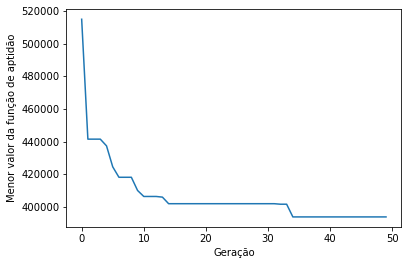

In [42]:
plt.plot(bests)
plt.ylabel('Menor valor da função de aptidão')
plt.xlabel('Geração')
plt.show()

# Resultado

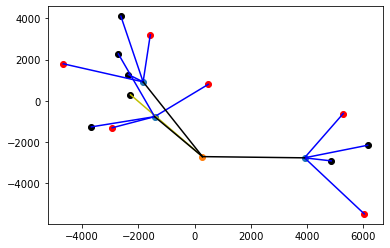

In [48]:
manifplot = manif.drop(manif[manif['X']==0].index, inplace=False)
coresP = {'P':'k', 'W':'r', 'A':'r'}
for g in pd.unique(pocos['Tipo']):
    toplot = pocos[pocos['Tipo']==g]
    plt.scatter(toplot['X'],toplot['Y'], color=coresP[g])
#plt.scatter(pocos['X'],pocos['Y'], color=coresP[pocos['Tipo']])
plt.scatter(manifplot.loc[1:,'X'],manifplot.loc[1:,'Y'])
plt.scatter(manifplot.at[0,'X'],manifplot.at[0,'Y'])
coresM = {'MSGL':'g', 'SDU':'b', 'MSIAG':'r', 'Plat':'y'}
for poco,manifold in enumerate(best_ever[0]):
    ponto1 = list(pocos.loc[poco,['X','Y']])
    ponto2 = list(manifplot.loc[manifold,['X','Y']])
    plt.plot([ponto1[0],ponto2[0]],[ponto1[1],ponto2[1]],color=coresM[manifplot.at[manifold,'Tipo']])
for manifold,dados in manifplot.iterrows():
    if manifold==0:
        ponto1 = list(dados.loc[['X','Y']])
    else:
        ponto2 = list(dados.loc[['X','Y']])
        plt.plot([ponto1[0],ponto2[0]],[ponto1[1],ponto2[1]],color='k')
plt.show()

In [46]:
manifplot

,X,Y,Tipo
0,280.312181,-2704.099739,Plat
8,-1832.408929,918.107646,SDU
10,-1422.371215,-768.174939,SDU
11,3910.779658,-2762.753196,SDU


To-do:<br>
- ~Plotar resultado com linhas~
- Melhorar algoritmo para não cair mais nos mínimos locais
- ~Incluir uma função de distância para as restrições~
- ~Usar o algoritmo simples para a localização da plataforma~
- Incluir custo ~(ou comprimento)~ de riser
- Melhorar cálculo dos custos para o modelo {fixo+distância*variável}

## Área de rascunho

In [27]:
ponto = [8, 9, 9, 10, 10, 8, 8, 9, 9, 0, 10, 8, 10]
best_ever = [ponto, CustoTotal(ponto,final=True)]

x = c

In [28]:
CustoTotal(ponto,final=True)

(371650.3081044813,)

In [25]:
print(pop[1])
print(pop[5])

[10361.792585919557, -10523.095813237302]
[8797.708554563516, 1578.3723804310575]


In [24]:
pocos

,Nome,X,Y,Tipo
0,WAG1,485.699422,796.459049,W
1,WAG2,6036.900474,-5480.519026,W
2,WAG3,5289.208571,-615.039582,W
3,WAG4,-1577.096057,3196.922295,W
4,WAG5,-4672.499098,1792.671609,W
5,WAG6,-2930.926974,-1306.364818,W
6,PO1,-2282.575846,298.398152,P
7,PO2,6157.279148,-2152.901390,P
8,PO3,4862.131934,-2910.836093,P
9,PO5,-2356.923793,1272.194585,P


In [8]:
pop = toolboxplat.population(n=100)
hof = tools.HallOfFame(1)

In [29]:
penalidade = pocos['Nome'].count()*LDA*5*custolin['principal_var'].max()
print(penalidade)

487500.0
